# Using Network Graphs To Visualize Potential Fraud on the Blockchain
### Author: On the Mark Data (Learn more at onthemarkdata.com!)
### Accompanying Blog: Coming Soon

Whether you are an NFT advocate or skeptic, one thing can't be denied-- the blockchain provides one of the largest public real-world datasets available to any data professional. In this notebook you will learn the following:
1. How to pull your own NFT data using the open source package `NFT Analyst Starter Pack` from a16z.
2. Understanding how to interpret Ethereum blockchain data.
3. Learn about the fraudulent practice of "wash trading" NFTs.
4. Constructing network graphs to visualize potential wash trading on the NFT project Bored Ape Yacht Club.

Important Notes:
- This is for educational purposes only and is not financial advice.
- This is only highlighting *potential* fraud, but does not prove fraud has taken place.
- If you own crypto, NEVER share your "secret recovery phrase" or "private keys" with anyone.

## Import Packages

In [16]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from string import ascii_uppercase
from operator import itemgetter

## Prepare Notebook Environment

In [62]:
# useful for ensuring long cryprto addresses can be fully seen
pd.set_option('display.max_colwidth', None)

# useful for making visible plots
plt.rcParams['figure.figsize'] = [10, 10]

## Import Data
There are multiple ways to pull blockchain data, below are some options:
- Create your own blockchain node (e.g. become a miner) to read the rawest data avaialable.
- Use a third party tool to create your own blockchain node.
- Use a third party API to read raw data from their own blockchain node.
- Use a third party API to read cleaned and aggregated blockchain data from their service.
- Use the the open source package `NFT Analyst Starter Pack` from a16z: https://github.com/a16z/nft-analyst-starter-pack

From top to bottom, the data access options trade off reliability/trust for convenience. For any blockchain analytics project, one must be aware of the tradeoffs of convenience and data rawness... but for this project, we want the most convenience possible to focus on learning.

Thus, we will use the `NFT Analyst Starter Pack` from a16z. Please follow the instructions on the package's GitHub page for setting up the script to pull your desired NFT data. This notebook analyzes the NFT project Bored Ape Yacht Club, so please use the contract address `0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d`. I have also included the data in this notebook's repository if you want to skip this step or replicate my exact results.

### BAYC Metadata
- Information regarding a specific NFT where asset_id is the unique identifier within this NFT token.
    - Note: On the blockchain, the unique identifier is the coposite key of the `asset_id` (i.e. "token id") and the contract address (i.e. the string representing the contract hash of thje respective NFT).
- `NaN`s are expected and inform that the respective NFT does not have the attribute in the represented column.
- Rarity scores are the proportion of `asset_id`s with a respective attribute.
    - Example:
        - ~33% of tokens within BAYC have a "Sea Captain's Hat."
        - ~4% of tokens have no hat as represented by `NaN`.
    - Considerations:
        - The importance of rarity scores is very dependent on the NFT project and overall sentiment of rarity within th NFT market as a whole.
        - Values such as perceived beauty, being "the first," and cultural significance (both on a micro and macro level) can supersede rarity.

Note: We won't be using this data, but thought it was important to share to help others learn more about NFTs and BAYC.

In [18]:
metadata = "metadata_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_metadata = pd.read_csv(f"../bayc_nft_data/{metadata}")
print(bayc_metadata.info())
bayc_metadata.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   asset_id                      10000 non-null  int64  
 1   attribute_count               10000 non-null  int64  
 2   attribute_count_rarity_score  10000 non-null  float64
 3   Hat_attribute                 7744 non-null   object 
 4   Hat_rarity_score              10000 non-null  float64
 5   Background_attribute          10000 non-null  object 
 6   Background_rarity_score       10000 non-null  float64
 7   Clothes_attribute             8114 non-null   object 
 8   Clothes_rarity_score          10000 non-null  float64
 9   Mouth_attribute               10000 non-null  object 
 10  Mouth_rarity_score            10000 non-null  float64
 11  Fur_attribute                 10000 non-null  object 
 12  Fur_rarity_score              10000 non-null  float64
 13  Ey

,asset_id,attribute_count,attribute_count_rarity_score,Hat_attribute,Hat_rarity_score,Background_attribute,Background_rarity_score,Clothes_attribute,Clothes_rarity_score,Mouth_attribute,Mouth_rarity_score,Fur_attribute,Fur_rarity_score,Eyes_attribute,Eyes_rarity_score,Earring_attribute,Earring_rarity_score,overall_rarity_score
0,0,6,1.878640,NaN,4.432624,Orange,7.855460,Striped Tee,24.271845,Discomfort,48.076923,Robot,37.735849,X Eyes,41.152263,Silver Hoop,11.337868,176.741472
1,1,5,3.937008,NaN,4.432624,Orange,7.855460,Vietnam Jacket,44.642857,Grin,14.025245,Robot,37.735849,Blue Beams,204.081633,NaN,1.423893,318.134569
2,2,5,3.937008,Sea Captain's Hat,32.894737,Aquamarine,7.898894,NaN,5.302227,Bored Cigarette,14.084507,Robot,37.735849,3d,20.533881,NaN,1.423893,123.810996
3,3,5,3.937008,NaN,4.432624,Purple,7.745933,Bone Necklace,49.261084,Tongue Out,49.504950,Cheetah,24.630542,Bored,5.834306,NaN,1.423893,146.770340
4,4,6,1.878640,Party Hat 2,93.457944,Blue,8.051530,Navy Striped Tee,29.940120,Phoneme L,41.493776,Golden Brown,12.853470,Closed,14.084507,NaN,1.423893,203.183880


### BAYC Sales
- One of the most powerful attributes of the blockchain is the ability to validate transaction for yourself via the `transaction_hash`
    - Go to etherscan.com and search the `transaction_hash` represented by `bayc_sales['transaction_hash'][0]` where you can find all information related to the transaction and the NFT.
    - Validate that the information represented in the dataframe matches etherscan.
        - Note: The `seller` address on etherscan is represented by an "ENS Domain" (i.e. the ".eth" names), but hovering over that value will show the expected address.
- `transaction_hash` will serve as the unique identifier and `seller` and `buyer` will be utilized to generate our network graph.

In [19]:
sales = "sales_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_sales = pd.read_csv(f"../bayc_nft_data/{sales}")
print(bayc_sales.info())
bayc_sales.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26310 entries, 0 to 26309
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_hash  26310 non-null  object 
 1   block_number      26310 non-null  int64  
 2   date              26310 non-null  object 
 3   asset_id          26310 non-null  int64  
 4   seller            26310 non-null  object 
 5   buyer             26310 non-null  object 
 6   maker             26310 non-null  object 
 7   taker             26310 non-null  object 
 8   sale_price_eth    26310 non-null  float64
 9   sale_price_usd    26310 non-null  float64
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB
None


,transaction_hash,block_number,date,asset_id,seller,buyer,maker,taker,sale_price_eth,sale_price_usd
0,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,153.200,442685.528567
1,0x1cf83a120540049239c62de9aa6cbc42bae7494cdf029419f2aa0b2df708e13b,14675814,2022-04-28,1397,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,139.750,403820.513167
2,0xf9854d2f02c074f1a2043bc93c5e4e6e4e922e6908a8d1a61ea1ea19e39a729c,14675812,2022-04-28,5226,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0xd30cad3f023888d5a81580fbb80f93102d69e9ef,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0x00000000a50bb64b4bbeceb18715748dface08af,150.000,433438.833453
3,0x38c03f0e17422b62f450262e2931a86efa201d3c22e908457a79a090cd935ab8,14675760,2022-04-28,6498,0x83e7fc69d7c99943afd9122ad0f8bb575e00597c,0x8dd47e819c53138aa18f8651d797e7969f34d1f1,0x83e7fc69d7c99943afd9122ad0f8bb575e00597c,0x8dd47e819c53138aa18f8651d797e7969f34d1f1,145.678,420950.015866
4,0x85ec6a319062f3537420ba60342ff273bbad907bfd9d7559628064455d4b7c26,14675332,2022-04-28,8028,0xe87cc2ea916a7d471976b675d5f72302908e4590,0x98bea99727b297f5eca448d1640075f349c08547,0xe87cc2ea916a7d471976b675d5f72302908e4590,0x98bea99727b297f5eca448d1640075f349c08547,128.000,369867.804547


### BAYC Transfers
- Another way to move an NFT asset to another wallet is via transfers.
- Keep in mind that transfers still require money to move (i.e. "gas fees"), but no money is sent to the receiving wallet.
- For legal transactions, transfers allow the owner to better organize their crypto walllets-- especially moving to wallets with extra security (e.g. cold wallets, and multi-sig authorization)
- For illegal transactions, hacked wallets typically result in the entire wallet contents being transffered to the hacker's respective wallet.

In [20]:
transfers = "transfers_0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D_04302022.csv"
bayc_transfers = pd.read_csv(f"../bayc_nft_data/{transfers}")
print(bayc_transfers.info())
bayc_transfers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67859 entries, 0 to 67858
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   transaction_hash  67859 non-null  object
 1   block_number      67859 non-null  int64 
 2   date              67859 non-null  object
 3   asset_id          67859 non-null  int64 
 4   from_address      67859 non-null  object
 5   to_address        67859 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.1+ MB
None


,transaction_hash,block_number,date,asset_id,from_address,to_address
0,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0xff389e55ee4dd64d82b2b6fefef3f7aa63b218fd,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88
1,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24
2,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762
3,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c
4,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc


## Prepare Data for Network Graph

### Sales Data

In [21]:
prepared_bayc_sales = bayc_sales \
    .copy() \
    .loc[:,[
        'transaction_hash',
        'block_number',
        'date',
        'asset_id',
        'seller',
        'buyer',
        'sale_price_eth',
        'sale_price_usd',
        ]
    ] \
    .rename(columns={'seller':'from_address', 'buyer':'to_address'}) \
    .assign(transaction_type='sell') \
    .astype({'block_number':'str', 'asset_id':'str'})

prepared_bayc_sales.head(3)


,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type
0,0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4,14675897,2022-04-28,7438,0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,153.20,442685.528567,sell
1,0x1cf83a120540049239c62de9aa6cbc42bae7494cdf029419f2aa0b2df708e13b,14675814,2022-04-28,1397,0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc,0x93d1f7636f56dd4498c778e212cbe3e2e15bcba9,139.75,403820.513167,sell
2,0xf9854d2f02c074f1a2043bc93c5e4e6e4e922e6908a8d1a61ea1ea19e39a729c,14675812,2022-04-28,5226,0x40c839b831c90173dc7fbce49a25274a4688ddd9,0xd30cad3f023888d5a81580fbb80f93102d69e9ef,150.00,433438.833453,sell


### Transfers Data

In [22]:
prepared_bayc_transfers = bayc_transfers \
    .copy() \
    .assign(
        sale_price_eth=0.00,
        sale_price_usd=0.00,
        transaction_type='transfer'
    ) \
    .astype({'block_number':'str', 'asset_id':'str'})

prepared_bayc_transfers.head(3)

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type
0,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0xff389e55ee4dd64d82b2b6fefef3f7aa63b218fd,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0.0,0.0,transfer
1,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x5f6ac80cdb9e87f3cfa6a90e5140b9a16a361d5c,0xdbfd76af2157dc15ee4e57f3f942bb45ba84af24,0.0,0.0,transfer
2,0x76b6196f390319fc3c0153bccb82c6e3667298a70d55458b3a756aa990679b3a,14675899,2022-04-28,5037,0x3b968d2d299b895a5fcf3bba7a64ad0f566e6f88,0x70b97a0da65c15dfb0ffa02aee6fa36e507c2762,0.0,0.0,transfer


#### Handling duplicate hashes for sales and transfers:
- The ethereum blockchain represents sales as both the exchange of ethereum as a "sale" and the exchange of the NFT as a "transfer" resulting in duplicates.
- This results in duplicate `transaction_hash`s for sale transactions where the transfer is also included.
- We need to remove these duplicate `transaction_hash`s for only the transfers.

Results:
- unique_sales_hash_list: 26113
- unique_transfer_hash_list: 54577
- unique_hash_set: 54577

The fact that the length `unique_hash_set` is not greater than `unique_transfer_hash_list` implies that unique sales `transaction_hash`s are within `unique_transfer_hash_list` as well.

In [23]:
unique_sales_hash_list = prepared_bayc_sales['transaction_hash'] \
    .unique() \
    .tolist()
print(len(unique_sales_hash_list))

unique_transfer_hash_list = prepared_bayc_transfers['transaction_hash'] \
    .unique() \
    .tolist()
print(len(unique_transfer_hash_list))

unique_hash_set = set(unique_sales_hash_list + unique_transfer_hash_list)
print(len(unique_hash_set))

26113
54577
54577


In [24]:
# repeating for readability across cells
unique_sales_hash_list = prepared_bayc_sales['transaction_hash'] \
    .unique() \
    .tolist()

# you can use `isin()` with a `~` for "not in" but I find `query()` to be more
# readable
filtered_prepared_bayc_transfers = prepared_bayc_transfers \
    .query('transaction_hash not in @unique_sales_hash_list')

print(len(filtered_prepared_bayc_transfers['transaction_hash']))

41585


### Combine Sales and Transfers Data
Note: I'm adding the NFT project's respective contract address as `asset_contract` as it will be useful for metadata later. All NFT projects on Ethereum will have a contract address and token ID (i.e. `asset_id`), which helps us identify specific NFTs on the blockchain. Most popular NFTs will have their own contract address, but some projects may have an "OpenSea Shared Storefront Contract" which is essentially a cheaper way to create an NFT project, but results in the contract address being shared among every NFT within the "OpenSea Shared Storefront" (making analytics very difficult).

In [25]:
prepared_bayc_sales_transfers = pd.concat(
    [prepared_bayc_sales, filtered_prepared_bayc_transfers]
    ) \
    .reset_index(drop=True) \
    .assign(asset_contract='0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d')

prepared_bayc_sales_transfers.describe(include =['object', 'float', 'int'])

,transaction_hash,block_number,date,asset_id,from_address,to_address,sale_price_eth,sale_price_usd,transaction_type,asset_contract
count,67895,67895,67895,67895,67895,67895,67895.000000,6.789500e+04,67895,67895
unique,54577,49989,372,10000,15320,19613,NaN,NaN,2,1
top,0x2d654336d0ce4ab3601951bf9e1d7b8474537b6273338d5f326af4d44bb25a70,12346915,2021-05-01,5520,0x0000000000000000000000000000000000000000,0xc310e760778ecbca4c65b6c559874757a4c4ece0,NaN,NaN,transfer,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
freq,51,85,11374,48,10000,1383,NaN,NaN,41585,67895
mean,NaN,NaN,NaN,NaN,NaN,NaN,8.589896,2.732988e+04,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,26.955004,8.581617e+04,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000e+00,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,1.550000,4.178787e+03,NaN,NaN


# Create Network Graph Data
Now it's time for the most fun part: creating the network graph! There are multiple way to construct a graph, but the easist in my opinion is to use the function `from_pandas_edgelist()`. Rather than 

- Documentation: https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html
- Further Reference: https://stackoverflow.com/questions/53834084/convert-pandas-dataframe-to-directed-networkx-multigraph

In [11]:
# directed graph
DG = nx.from_pandas_edgelist(
    df=prepared_bayc_sales_transfers,
    source='from_address',
    target='to_address',
    edge_attr=True,
    create_using=nx.DiGraph()
)

# confirm it's correct graph
print(f'Is graph directed: {DG.is_directed()}')
print(f'Is multigraph: {DG.is_multigraph()}')

# view the first two nodes with edge data
list(DG.edges(data=True))[0:2]

Is graph directed: True
Is multigraph: False


[('0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3',
  '0xcedf17dfafa947cd0e205fe2a3a183cf2fb3a0bc',
  {'transaction_hash': '0xb235f0321b0b50198399ec7f2bb759ef625f85673b4d90d68f711229750181e4',
   'block_number': '14675897',
   'date': '2022-04-28',
   'asset_id': '7438',
   'sale_price_eth': 153.2,
   'sale_price_usd': 442685.5285671361,
   'transaction_type': 'sell'}),
 ('0x2fdcca65899346af3a93a8daa6128bdbcb1ce3b3',
  '0xd8fdd6031fa27194f93e1a877f8bf5bfc9b47e1e',
  {'transaction_hash': '0x7b4797061eb16d73a28a869e51745e471e2849a55c80459b2aff7f0205925d74',
   'block_number': '14654313',
   'date': '2022-04-25',
   'asset_id': '5954',
   'sale_price_eth': 0.0,
   'sale_price_usd': 0.0,
   'transaction_type': 'transfer'})]

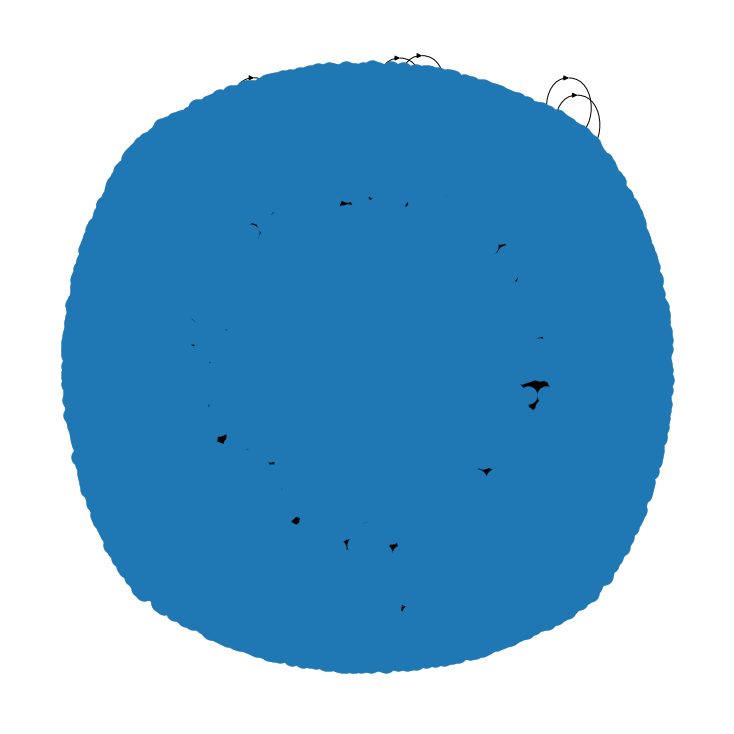

In [64]:
# takes about 25min
nx.draw(DG)

## Putting It All Together

Now that we have a graph to start off with, we now need to add more detail for our audience to unsderstand what they are looking at within this graph. Emphasis on telling a story of the transictions of a particular NFT.
- https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

In [63]:
class NftToNetworkGraph:
    def __init__(self, nft_transactions_data: pd.DataFrame) -> None:
        self.nft_transactions_data = nft_transactions_data
    
    def _filter_to_specific_nft(self, nft_data: pd.DataFrame, asset_id: str) -> pd.DataFrame:
        df = nft_data.copy()
        
        filtered_nft_data = df.loc[df['asset_id']==asset_id]

        if len(filtered_nft_data) == 0:
            asset_contract = df['asset_contract'][0]
            etherscan_link = f'https://etherscan.io/token/{asset_contract}?a={asset_id}'
            raise Exception(
                f'No transactions found for asset {asset_id}. Investigate' \
                f'further on Etherscan: {etherscan_link}'
                )

        return filtered_nft_data
    
    # this function is a great candidate for refactoring later
    def _get_ordered_node_labels(self, nft_data: pd.DataFrame) -> pd.DataFrame:
        df = nft_data.copy()

        unique_ordered_from_addresses = df \
            .loc[:,['from_address', 'date']] \
            .rename(columns={'from_address':'address'})
        
        unique_ordered_to_addresses = df \
            .loc[:,['to_address', 'date']] \
            .rename(columns={'to_address':'address'})
        
        unique_ordered_all_addresses = pd.concat(
            [unique_ordered_from_addresses, unique_ordered_to_addresses]
            ) \
            .groupby('address') \
            .agg('min') \
            .sort_values('date', ascending=True) \
            .reset_index()
        
        # https://stackoverflow.com/questions/50860366/pandas-set-row-values-to-letter-of-the-alphabet-corresponding-to-index-number
        # get upper case letter in order of index
        node_label_series = pd.Series(
            itemgetter(*unique_ordered_all_addresses.index)(ascii_uppercase),
            name='node_label'
            )
        address_labels_df = pd.concat(
            [unique_ordered_all_addresses, node_label_series], axis=1
            ) \
            .loc[:,['address', 'node_label']]

        from_node_label_df = df \
            .merge(address_labels_df, how='left', left_on='from_address', right_on='address') \
            .rename(columns={'node_label':'from_node_label'})
        
        to_from_node_label_df = from_node_label_df \
            .merge(address_labels_df, how='left', left_on='to_address', right_on='address') \
            .rename(columns={'node_label':'to_node_label'})
        
        # drop duplicate merge columns
        to_from_node_label_df.drop(columns=['address_x', 'address_y'], axis=1, inplace=True)

        return to_from_node_label_df
    
    def prepare_nft_data(self, asset_id: str) -> pd.DataFrame:
        nft_df = self.nft_transactions_data.copy()
        filtered_df = self._filter_to_specific_nft(nft_df, asset_id)
        label_df = self._get_ordered_node_labels(filtered_df)

        return label_df

    
    def generate_network(self, prepared_nft_data: pd.DataFrame) -> nx.classes.digraph.DiGraph:
        asset_dg = nx.from_pandas_edgelist(
            df=prepared_nft_data,
            source='from_node_label',
            target='to_node_label',
            edge_attr=True,
            create_using=nx.DiGraph()
            )
        return asset_dg
    
    def print_asset_meta_data_report(self, asset_id: str) -> None:
        prepared_nft_data = self.prepare_nft_data(asset_id)
        asset_contract = prepared_nft_data['asset_contract'][0]
        sell_nft_data = prepared_nft_data[prepared_nft_data['transaction_type']=='sell']
        transfer_nft_data = prepared_nft_data[prepared_nft_data['transaction_type']=='transfer']

        from_addresses_data = prepared_nft_data \
            .loc[:,['from_address', 'from_node_label']] \
            .rename(columns={'from_address':'address', 'from_node_label':'node_label'})
        
        to_addresses_data = prepared_nft_data \
            .loc[:,['to_address', 'to_node_label']] \
            .rename(columns={'to_address':'address', 'to_node_label':'node_label'})
        
        adresses_data = pd.concat(
            [from_addresses_data, to_addresses_data]
            ) \
            .drop_duplicates() \
            .sort_values(by=['node_label'], ascending=True) \
            .rename({'from_address':'adress', 'from_node_label':'node_label'}) \
            .reset_index(drop=True)

        report_text = f'''
        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: {asset_contract}
        Asset ID: {asset_id}
        OpenSea: https://opensea.io/assets/ethereum/{asset_contract}/{asset_id}
        Etherscan: https://etherscan.io/token/{asset_contract}?a={asset_id}
        Mint Date: {min(prepared_nft_data['date'])}
        Latest Recorded Transaction Date: {max(prepared_nft_data['date'])}
        Times Sold: {len(sell_nft_data)}
        Times Transferred: {len(transfer_nft_data)}
        Min Sell Price: ${int(min(sell_nft_data['sale_price_usd'], default=0))}
        Max Sell Price: ${int(max(sell_nft_data['sale_price_usd'], default=0))}
        Unique Wallet Holder Count: {len(adresses_data)}
        Wallet Address to Node Label Key:
        {adresses_data}
        '''

        print(report_text)

    def generate_graph_from_asset_id(self, asset_id: str) -> None:
        prepared_nft_data = self.prepare_nft_data(asset_id)
        asset_dg = self.generate_network(prepared_nft_data)

        # planar_layout positionsq nodes without edge intersections
        pos = nx.planar_layout(asset_dg)
        nx.draw(
            G=asset_dg,
            pos=pos,
            arrowsize=15,
            connectionstyle='arc3, rad = 0.05',
            node_color='black',
            with_labels=True,
            node_size=500,
            # cmap
            width=1.5
            )
        nx.draw_networkx_labels(G=asset_dg, pos=pos, font_color='whitesmoke')
        nx.draw_networkx_edge_labels(
            asset_dg,
            pos=pos,
            edge_labels=nx.get_edge_attributes(asset_dg,'sale_price_usd'))
        plt.title(f'Bored Ape Yacht Club: Asset ID {asset_id}')
        plt.show()
    
    def generate_asset_report(self, asset_id: str) -> None:
        self.print_asset_meta_data_report(asset_id)
        self.generate_graph_from_asset_id(asset_id)


        +-----------------------+
        | BAYC NFT Asset Report |
        +-----------------------+
        Contract Address: 0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d
        Asset ID: 8099
        OpenSea: https://opensea.io/assets/ethereum/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/8099
        Etherscan: https://etherscan.io/token/0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d?a=8099
        Mint Date: 2021-05-01
        Latest Recorded Transaction Date: 2021-11-04
        Times Sold: 5
        Times Transferred: 7
        Min Sell Price: $40528
        Max Sell Price: $276462
        Unique Wallet Holder Count: 11
        Wallet Address to Node Label Key:
                                               address node_label
0   0x0000000000000000000000000000000000000000          A
1   0x442dccee68425828c106a3662014b4f131e3bd9b          B
2   0x8ad272ac86c6c88683d9a60eb8ed57e6c304bb0c          C
3   0x7d88aa989068e65190031a13c809e27fcb3aca52          D
4   0xfa68378c74d13a9509fefd0a09e

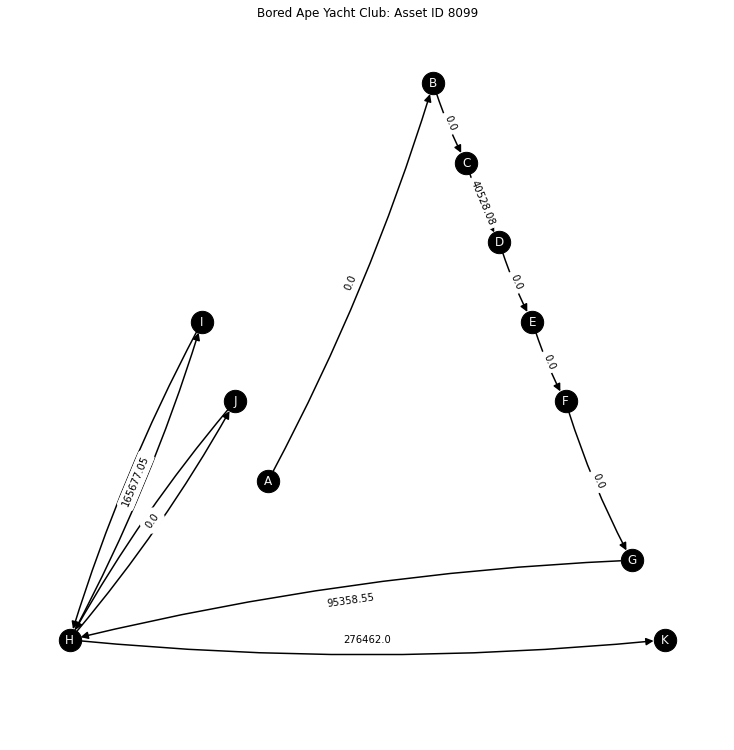

In [61]:
nft_to_graph = NftToNetworkGraph(prepared_bayc_sales_transfers)
nft_to_graph.generate_asset_report('8099')

## Final Thoughts
